In [33]:
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import random
import cv2
from pycocotools.coco import COCO
import time

import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.models import mobilenet_v3_large
import torch.nn as nn
from torch.nn import functional as F

In [3]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d watchman/rtsd-dataset
!unzip rtsd-dataset.zip
!rm rtsd-dataset.zip
!cp -r rtsd-frames/rtsd-frames/ .
!rm -r rtsd-frames/rtsd-frames/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_47_1.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_53_0.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_53_1.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_53_2.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_54_0.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_54_1.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_54_2.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_55_0.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_55_1.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_55_2.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_55_3.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_11_19_56_0.jpg  
  inflating: rtsd-frames/rtsd-frames/autosave24_10_2013_

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
!cp chkpt_model2ra_d_0.pth /content/drive/MyDrive
!cp chkpt_model2ra_d_1.pth /content/drive/MyDrive
!cp chkpt_model2ra_d_2.pth /content/drive/MyDrive
!cp chkpt_model2ra_d_3.pth /content/drive/MyDrive
!cp chkpt_model2ra_d_4.pth /content/drive/MyDrive
!cp chkpt_model2ra_d_5.pth /content/drive/MyDrive
!cp chkpt_model2ra_d_6.pth /content/drive/MyDrive
!cp chkpt_model2ra_d_7.pth /content/drive/MyDrive
!cp chkpt_model2ra_d_8.pth /content/drive/MyDrive
# !cp chkpt_model2ra_d_9.pth /content/drive/MyDrive
!cp chkpt_m2ra_d_0.pth /content/drive/MyDrive
!cp chkpt_m2ra_d_1.pth /content/drive/MyDrive
!cp chkpt_m2ra_d_2.pth /content/drive/MyDrive
!cp chkpt_m2ra_d_3.pth /content/drive/MyDrive
!cp chkpt_m2ra_d_4.pth /content/drive/MyDrive
!cp chkpt_m2ra_d_5.pth /content/drive/MyDrive
!cp chkpt_m2ra_d_6.pth /content/drive/MyDrive
!cp chkpt_m2ra_d_7.pth /content/drive/MyDrive
!cp chkpt_m2ra_d_8.pth /content/drive/MyDrive
# !cp chkpt_m2ra_d_9.pth /content/drive/MyDrive

cp: cannot stat 'chkpt_model2ra_d_9.pth': No such file or directory
cp: cannot stat 'chkpt_m2ra_d_9.pth': No such file or directory


In [2]:
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'

n_epochs = 10
batch_size = 6
classes = 2
classes1 = 156
device

'cuda:0'

In [4]:
# функция загрузки датасета в pd
def dataset(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
  
  return df

In [5]:
df_train_anno = dataset('.', 'train_anno.json')
df_val_anno = dataset('.', 'val_anno.json')
df_train_anno_reduced = dataset('.', 'train_anno_reduced.json')

In [6]:
class RTSD_dataset_clf_my(Dataset):
    def __init__(self, path_img, df, transforms=None):
        super().__init__()
        self.path_img = path_img
        self.transforms = transforms
        self.df = df
        
    def __getitem__(self, index):
        name_img = self.df.loc[index,'file_name']
        boxes = self.df.loc[index,'bbox']
        bb = [boxes[0], boxes[1], boxes[0] + boxes[2], boxes[1] + boxes[3]]
        imgs = Image.open(os.path.join(self.path_img, name_img))
        imgs = imgs.crop(bb)

        if self.transforms is not None:
            imgs = self.transforms(imgs)

        imgs = imgs / 255

        targets = torch.tensor(self.df.loc[index, 'category_id'])


#         return imgs, targets
        return {
                'images': imgs,
                'targets': targets}
    
    def __len__(self):
        
        return self.df.shape[0]

In [7]:
def get_transform1():
#     custom_transforms = []
#     custom_transforms.append(transforms.ToTensor())
    return transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])

In [8]:
def get_transform_a1():
             return transforms.Compose([transforms.Resize((512,512)),
                    transforms.RandomChoice([transforms.Compose([transforms.RandomPerspective(), transforms.ToTensor()]),
                    transforms.Compose([transforms.ColorJitter(), transforms.ToTensor()]),
                    transforms.Compose([transforms.RandomResizedCrop((512,512)),transforms.ToTensor()]),
                    transforms.Compose([transforms.ToTensor(),transforms.RandomErasing()])])])

In [9]:
df12 = RTSD_dataset_clf_my('./', df_train_anno_reduced, transforms=get_transform1())
df112 = RTSD_dataset_clf_my('./', df_val_anno, transforms=get_transform1())
df222 = RTSD_dataset_clf_my('./', df_train_anno_reduced, transforms=get_transform_a1())
df122 = RTSD_dataset_clf_my('./', df_val_anno, transforms=get_transform_a1())

In [10]:
data_loader_train12 = torch.utils.data.DataLoader(df12,
                                          batch_size=batch_size,
                                          shuffle=True, drop_last = True)

data_loader_val12 = torch.utils.data.DataLoader(df112,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last = True)
data_loader_train22 = torch.utils.data.DataLoader(df222,
                                          batch_size=batch_size,
                                          shuffle=True, drop_last = True)

data_loader_val22 = torch.utils.data.DataLoader(df122,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last = True)

In [11]:
def show_tranformed_image2(train_loader):
    if len(train_loader) > 0:
        for i in range(1):
            data = next(iter(train_loader))
            images, targets = data['images'], data['targets']
#             images, targets = next(iter(train_loader))
            images = list(image.to(device) for image in images)
            sample = images[i].permute(1, 2, 0).detach().cpu().numpy()
            sample = sample * 255
            targets = [t.to(device) for t in targets]
            targets = targets[i].item()
            
            plt.imshow(sample)
            plt.title(targets)
            plt.axis('off')
            plt.show()

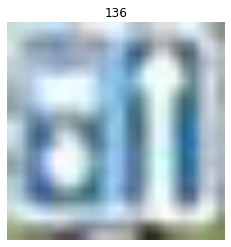

In [12]:
show_tranformed_image2(data_loader_train22)

In [13]:
def show_tranformed_image12(train_loader):
            figure = plt.figure(figsize=(10, 8))
            cols, rows = 3, 3
            if len(train_loader) > 0:
                  for i in range(1, cols * rows + 1):
                              for j in range(1):
                                  data = next(iter(train_loader))
                                  images, targets = data['images'], data['targets']
                                    
#                                   images, targets = next(iter(train_loader))
#                                   images = list(image.to(device) for image in images)
#                                   targets = [t.to(device) for t in targets]
                                  targets = targets[j].item()
                                  sample = images[j].permute(1, 2, 0).detach().cpu().numpy()
                                  sample = sample * 255
                                  figure.add_subplot(rows, cols, i)
                                                    
                                  plt.imshow(sample)
                                  
                                  plt.title(targets)
                                  plt.axis("off")
            plt.show()

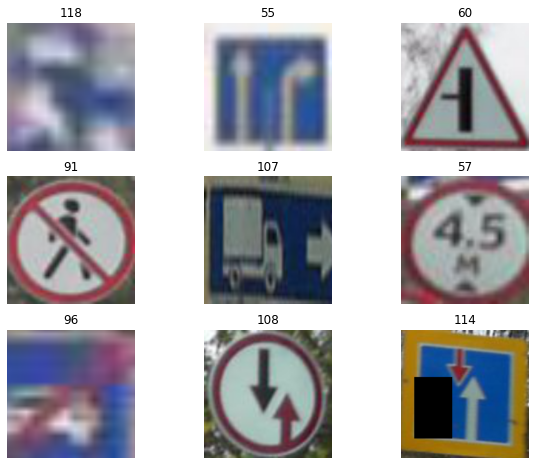

In [14]:
show_tranformed_image12(data_loader_train22)

In [24]:
def build_model_clf(classes):
    model = mobilenet_v3_large(weights=None)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[3] = nn.Linear(in_features=model.classifier[3].in_features, out_features=classes)
#     model.classifier[3] = nn.Linear(in_features=1280, out_features=classes)
    for param in  model.classifier.parameters():
        param.requires_grad = True

    return model

In [ ]:
# def load_ckp(checkpoint_fpath, model, optimizer):
#     """
#     checkpoint_path: path to save checkpoint
#     model: model that we want to load checkpoint parameters into       
#     optimizer: optimizer we defined in previous training
#     """
#     # load check point
#     checkpoint = torch.load(checkpoint_fpath, map_location=device)
#     # initialize state_dict from checkpoint to model
#     model.load_state_dict(checkpoint['model_state_dict'])
#     # initialize optimizer from checkpoint to optimizer
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     # initialize valid_loss_min from checkpoint to valid_loss_min
#     valid_loss_min = checkpoint['loss_val']
#     # return model, optimizer, epoch value, min validation loss 
#     return model, optimizer, checkpoint['epoch'], valid_loss_min

# model1 = build_model_clf(2).to(device)
# params1 = [p for p in model1.parameters() if p.requires_grad]
# optimizer1 = torch.optim.Adam(params1)
# loss_func = nn.CrossEntropyLoss()

# model, optimizer, start_epoch, valid_loss = load_ckp('./chkpt_model1r_clf_7.pth', model1, optimizer1)

In [ ]:
# def load_ckp1(checkpoint_fpath, model):
#     """
#     checkpoint_path: path to save checkpoint
#     model: model that we want to load checkpoint parameters into       
#     optimizer: optimizer we defined in previous training
#     """
#     # load check point
#     checkpoint = torch.load(checkpoint_fpath, map_location=device)
#     # initialize state_dict from checkpoint to model
#     model.load_state_dict(checkpoint)
    
#     return model

# model1 = build_model_clf(2).to(device)
# params1 = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params1)
# loss_func = nn.CrossEntropyLoss()

# model = load_ckp1('./chkpt_model1_clf_7.pth', model1)

In [18]:
model = build_model_clf(classes1).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params)
loss_func = nn.CrossEntropyLoss()

In [17]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []   

for epoch in range(n_epochs):
    start = time.time()
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, batch in enumerate(data_loader_train12):
        optimizer.zero_grad()
        image, targets = batch['images'].to(device), batch['targets'].to(device)
#         image = list(img.to(device) for img in image)
#         targets = [t.to(device) for t in targets]
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = loss_func(outputs, targets)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs, 1)
        train_running_correct += (preds == targets).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()     
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    
    # Loss and accuracy for the complete epoch.
    train_epoch_loss = train_running_loss / i
    train_epoch_acc = 100. * (train_running_correct / len(df12))
    
    print('Эпоха train:', epoch,'Итераций:', i, 'train loss:', train_epoch_loss, 'train acc:', train_epoch_acc)
    
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    # We need two lists to keep track of class-wise accuracy.
    class_correct = list(0. for i in range(classes1))
    class_total = list(0. for i in range(classes1))
    with torch.no_grad():
        for i, batch in enumerate(data_loader_val12):
#             image, targets = batch
            image, targets = batch['images'].to(device), batch['targets'].to(device)
#             image = list(img.to(device) for img in image)
#             targets = [t.to(device) for t in targets]
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = loss_func(outputs, targets)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs, 1)
            valid_running_correct += (preds == targets).sum().item()
            # Calculate the accuracy for each class.
            correct  = (preds == targets).squeeze()
            for j in range(len(preds)):
                label = targets[j]
                # print(label)
                class_correct[label] += correct[j].item()
                class_total[label] += 1
        
            if i % 200 == 0:
                 print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
        
    # Loss and accuracy for the complete epoch.
    valid_epoch_loss = valid_running_loss / i
    valid_epoch_acc = 100. * (valid_running_correct / len(df112))
    
    end = time.time()
    print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
    print('Эпоха val:', epoch, 'Итераций:', i, 'val loss:', valid_epoch_loss, 'val acc:', valid_epoch_acc)
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    
    torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss_train': train_loss,
                    'acc_train': train_acc,
                    'loss_val': valid_loss,
                    'acc_val': valid_acc
                    }, f'./chkpt_model1r_clf_{epoch}.pth')
    
    torch.save(model.state_dict(), f'./chkpt_m1r_clf_{epoch}.pth')

epoch: 0, step: 0, loss: 5.037479877471924
epoch: 0, step: 200, loss: 3.9310452938079834
Эпоха train: 0 Итераций: 386 train loss: 4.619404153502667 train acc: 6.838709677419355
epoch: 0, step: 0, loss: 4.8155694007873535
epoch: 0, step: 200, loss: 5.154613971710205
epoch: 0, step: 400, loss: 5.023691654205322
epoch: 0, step: 600, loss: 5.062527656555176
epoch: 0, step: 800, loss: 5.122700214385986
epoch: 0, step: 1000, loss: 5.117549419403076
epoch: 0, step: 1200, loss: 5.080883026123047
epoch: 0, step: 1400, loss: 5.026397228240967
Потрачено 5.4 минут на 0 эпоху
Эпоха val: 0 Итераций: 1476 val loss: 5.0204372435081295 val acc: 1.4098804421385067
epoch: 1, step: 0, loss: 4.1661376953125
epoch: 1, step: 200, loss: 4.212512493133545
Эпоха train: 1 Итераций: 386 train loss: 3.4271829276504913 train acc: 21.247311827956988
epoch: 1, step: 0, loss: 4.759083271026611
epoch: 1, step: 200, loss: 4.055103778839111
epoch: 1, step: 400, loss: 4.142789840698242
epoch: 1, step: 600, loss: 3.9082822

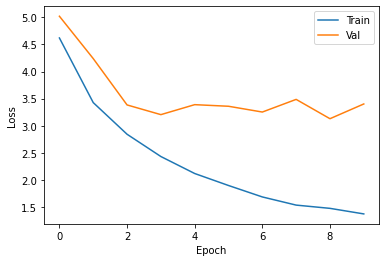

In [44]:
fig, ax  = plt.subplots()
ax.plot(train_loss, label='Train')
ax.plot(valid_loss, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.savefig("loss2.png")
ax.legend()

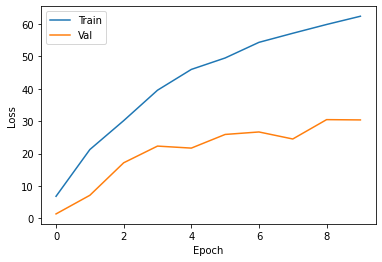

In [45]:
fig, ax  = plt.subplots()
ax.plot(train_acc, label='Train')
ax.plot(valid_acc, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.savefig("loss2.png")
ax.legend()

In [25]:
train1_loss, valid1_loss = [], []
train1_acc, valid1_acc = [], []   

for epoch in range(n_epochs):
    start = time.time()
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, batch in enumerate(data_loader_train22):
        optimizer.zero_grad()
        image, targets = batch['images'].to(device), batch['targets'].to(device)
#         image = list(img.to(device) for img in image)
#         targets = [t.to(device) for t in targets]
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = loss_func(outputs, targets)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs, 1)
        train_running_correct += (preds == targets).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()     
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    
    # Loss and accuracy for the complete epoch.
    train_epoch_loss = train_running_loss / i
    train_epoch_acc = 100. * (train_running_correct / len(df222))
    
    print('Эпоха train:', epoch,'Итераций:', i, 'train loss:', train_epoch_loss, 'train acc:', train_epoch_acc)
    
    model.eval()
    valid_running_loss = 0.0
    valid_running_correct = 0
    # We need two lists to keep track of class-wise accuracy.
    class_correct = list(0. for i in range(classes1))
    class_total = list(0. for i in range(classes1))
    with torch.no_grad():
        for i, batch in enumerate(data_loader_val22):
#             image, targets = batch
            image, targets = batch['images'].to(device), batch['targets'].to(device)
#             image = list(img.to(device) for img in image)
#             targets = [t.to(device) for t in targets]
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = loss_func(outputs, targets)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs, 1)
            valid_running_correct += (preds == targets).sum().item()
            # Calculate the accuracy for each class.
            correct  = (preds == targets).squeeze()
            for j in range(len(preds)):
                label = targets[j]
                # print(label)
                class_correct[label] += correct[j].item()
                class_total[label] += 1
        
            if i % 200 == 0:
                 print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
        
    # Loss and accuracy for the complete epoch.
    valid_epoch_loss = valid_running_loss / i
    valid_epoch_acc = 100. * (valid_running_correct / len(df122))
    
    end = time.time()
    print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
    print('Эпоха val:', epoch, 'Итераций:', i, 'val loss:', valid_epoch_loss, 'val acc:', valid_epoch_acc)
    
    train1_loss.append(train_epoch_loss)
    valid1_loss.append(valid_epoch_loss)
    train1_acc.append(train_epoch_acc)
    valid1_acc.append(valid_epoch_acc)
    
    torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss_train': train1_loss,
                    'acc_train': train1_acc,
                    'loss_val': valid1_loss,
                    'acc_val': valid1_acc
                    }, f'./chkpt_model12r_clf_{epoch}.pth')
    
    torch.save(model.state_dict(), f'./chkpt_m12r_clf_{epoch}.pth')

epoch: 0, step: 0, loss: 4.9953932762146
epoch: 0, step: 200, loss: 4.912296295166016
Эпоха train: 0 Итераций: 386 train loss: 4.8702790088604155 train acc: 3.9569892473118284
epoch: 0, step: 0, loss: 5.488323211669922
epoch: 0, step: 200, loss: 5.448690414428711
epoch: 0, step: 400, loss: 5.365055561065674
epoch: 0, step: 600, loss: 5.106953144073486
epoch: 0, step: 800, loss: 5.54760217666626
epoch: 0, step: 1000, loss: 5.462261199951172
epoch: 0, step: 1200, loss: 5.311676025390625
epoch: 0, step: 1400, loss: 5.3048810958862305
Потрачено 5.5 минут на 0 эпоху
Эпоха val: 0 Итераций: 1476 val loss: 5.318387145272438 val acc: 0.03383713061132416
epoch: 1, step: 0, loss: 3.568293809890747
epoch: 1, step: 200, loss: 3.7069244384765625
Эпоха train: 1 Итераций: 386 train loss: 4.042565898574078 train acc: 11.13978494623656
epoch: 1, step: 0, loss: 4.65292501449585
epoch: 1, step: 200, loss: 4.388111114501953
epoch: 1, step: 400, loss: 4.560667991638184
epoch: 1, step: 600, loss: 4.132326126

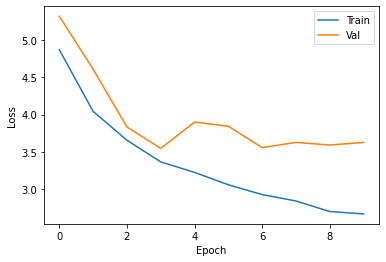

In [46]:
fig, ax  = plt.subplots()
ax.plot(train1_loss, label='Train')
ax.plot(valid1_loss, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.savefig("loss2.png")
ax.legend()

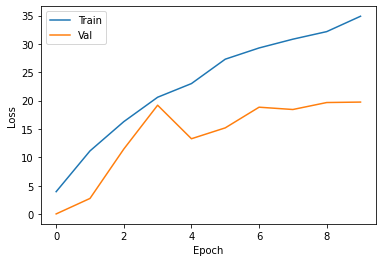

In [47]:
fig, ax  = plt.subplots()
ax.plot(train1_acc, label='Train')
ax.plot(valid1_acc, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.savefig("loss2.png")
ax.legend()

In [27]:
def anno_1_class(anno_file):
    
    with open(os.path.join('.', anno_file), 'r') as read_file:
        anno_json = json.load(read_file)
    read_file.close()

    for i in range(len(anno_json['annotations'])):
        anno_json['annotations'][i]['category_id'] = 1    
    
    anno_json['categories'] = [{'id': 1, 'name': 'rtsd'}]
    
    anno_file_new = anno_file.split('.')[0] + '_1.json'
    
    with open(os.path.join('.', anno_file_new), 'w') as f:
        json.dump(anno_json, f)
    f.close()

    return anno_json

In [28]:
train_anno_1 = anno_1_class('train_anno.json')
val_anno_1 = anno_1_class('val_anno.json')
train_anno_reduced_1 = anno_1_class('train_anno_reduced.json')

In [29]:
class RTSD_dataset_coco(Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]["file_name"]
        # open the input image
        img = Image.open(os.path.join(self.root, path))
    
        
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]["bbox"][0]
            ymin = coco_annotation[i]["bbox"][1]
            xmax = xmin + coco_annotation[i]["bbox"][2]
            ymax = ymin + coco_annotation[i]["bbox"][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]["area"])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
        
        img = img/255
    
        return img, my_annotation
    
    def __len__(self):
        return len(self.ids)

In [30]:
def get_transform_a():
             return transforms.Compose([transforms.Resize((512,512)),
                    transforms.RandomChoice([transforms.Compose([transforms.RandomPerspective(), transforms.ToTensor()]),
                    transforms.Compose([transforms.ColorJitter(), transforms.ToTensor()]),
                    transforms.Compose([transforms.RandomResizedCrop((512,512)),transforms.ToTensor()]),
                    transforms.Compose([transforms.ToTensor(),transforms.RandomErasing()])])])

In [31]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [34]:
root = '.'
annotation = './train_anno_reduced_1.json'

# create own Dataset
df2 = RTSD_dataset_coco(root=root,
                          annotation=annotation,
                          transforms=get_transform_a()
                          )
# df2.__getitem__(100)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [36]:
root = '.'
annotation = './val_anno_1.json'

# create own Dataset
df22 = RTSD_dataset_coco(root=root,
                          annotation=annotation,
                          transforms=get_transform_a()
                          )
# df22.__getitem__(100)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [37]:
data_loader_train2 = torch.utils.data.DataLoader(df2,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn)


In [38]:
data_loader_val2 = torch.utils.data.DataLoader(df22,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn)

In [39]:
def build_model(n_model, classes):
    if 'resnet50_fpn_v2' in n_model:
        model =torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT')
    elif 'resnet50_fpn' in n_model:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    else:
        print("нет такой модели ")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, classes)
    
    return model

In [40]:
model1 = build_model('resnet50_fpn', 2).to(device)
params1 = [p for p in model1.parameters() if p.requires_grad]
optimizer1 = torch.optim.Adam(params1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [41]:
loss1_train = []
loss1_val = []

for epoch in range(n_epochs):
    start = time.time()
    model1.train()
    for i, batch in enumerate(data_loader_train2):
        optimizer1.zero_grad()
        loss_train = 0
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model1(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_train += losses.item()
        losses.backward()
        optimizer1.step()
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {losses.item()}')
    
    loss11_train = (loss_train / i)
    loss1_train.append(loss11_train)
    
    print('Эпоха train:', epoch,'Итераций:', i, 'train loss:', (loss_train / i))
    
    for i, batch in enumerate(data_loader_val2):
        optimizer1.zero_grad()
        loss_val = 0
        imgs, targets = batch
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
              loss_dict = model1(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_val += losses.item()
        
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {losses.item()}')
    
    loss11_val = (loss_val / i)
    loss1_val.append(loss11_val)
    end = time.time()
    print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
    print('Эпоха val:', epoch, 'Итераций:', i, 'val loss:', (loss_val / i))
    
        
    torch.save({'epoch': epoch,
                    'model_state_dict': model1.state_dict(),
                    'optimizer_state_dict': optimizer1.state_dict(),
                    'loss_train': loss1_train,
                    'loss_val': loss1_val,
                    }, f'./chkpt_model2ra_d_{epoch}.pth')
    
    torch.save(model1.state_dict(), f'./chkpt_m2ra_d_{epoch}.pth')


epoch: 0, step: 0, loss: 31.583757400512695
epoch: 0, step: 200, loss: 13.231738090515137
Эпоха train: 0 Итераций: 314 train loss: 0.04295936511580352
epoch: 0, step: 0, loss: 92.15607452392578
epoch: 0, step: 200, loss: 119.60408020019531
epoch: 0, step: 400, loss: 111.35707092285156
epoch: 0, step: 600, loss: 63.604881286621094
epoch: 0, step: 800, loss: 81.638671875
Потрачено 14.8 минут на 0 эпоху
Эпоха val: 0 Итераций: 833 val loss: 0.07737796962046538
epoch: 1, step: 0, loss: 47.7524299621582
epoch: 1, step: 200, loss: 19.96796226501465
Эпоха train: 1 Итераций: 314 train loss: 0.03919818902471263
epoch: 1, step: 0, loss: 9.088053703308105
epoch: 1, step: 200, loss: 26.951255798339844
epoch: 1, step: 400, loss: 29.163354873657227
epoch: 1, step: 600, loss: 12.353261947631836
epoch: 1, step: 800, loss: 9.847232818603516
Потрачено 14.5 минут на 1 эпоху
Эпоха val: 1 Итераций: 833 val loss: 0.01405242539825989
epoch: 2, step: 0, loss: 11.06550121307373
epoch: 2, step: 200, loss: 59.635

KeyboardInterrupt: ignored

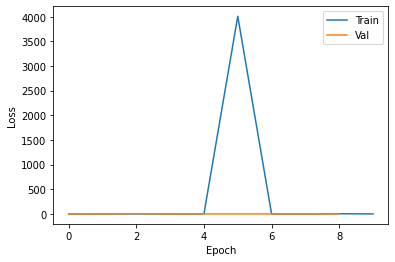

In [42]:
fig, ax  = plt.subplots()
ax.plot(loss1_train, label='Train')
ax.plot(loss1_val, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.savefig("loss2.png")
ax.legend()